# ДЗ1 - имитационное обучение
Крайний срок сдачи - 20.02.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: смотреть, что такое клонирование поведеня и разобраться с алгоритмом DAgger.
Вместо человека-демонстранта демонстрации будут даваться специальной предобученной "экспертной" стартегией. Ваша задача будет заключаться в реализации алгоритма клонирования и DAgger, сравнения их произвоодительости на нескольких простых задачах управления из пакета OpenAI Gym. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/uNq18mDY284JdI7o5KgJ) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

__Будьте винимательны!__ В заготовках кода ниже могут быть неточности! Их правка входит в задачу выполнения ДЗ! Как минимум, вам нужно дописывать строчик кода ниже пометок __Ваш код здесь__.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__<br>
Будем использовать набор симуляционных сред MuJoCo.  Загружайте версию 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа можно испоьзовать ваше университетский аккаунт -  https://www.roboti.us/license.html.
***

In [1]:
# ! which pip

In [2]:
# ! pip install glfw
# ! pip install -U 'mujoco-py<1.50.2,>=1.50.1'

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util

import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

import matplotlib.pyplot as plt

TensorFlow version : 1.13.1
Gym version : 0.10.5


***
## Сборием статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [2]:
### Для удобства переиспользования весь приведенный код я переоформил в функции



#choose environment (Uncomment choosed one)
# env_name="Humanoid-v2"
# env_name="Ant-v2"
# env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

In [3]:
# # choose expert policy file from /expert file
# expert_policy_file="experts/"+env_name+".pkl"

# # load the policy
# print('loading and building expert policy')
# policy_fn = load_policy.load_policy(expert_policy_file)
# print('loaded and built')

# # make the environment
# env = gym.make(env_name)

# function to generate rollouts from the expert policies 
def generate_rollouts(num_rollouts,max_steps,env,policy_fn,render=False):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            #number of iteration (episode)
            #print('iter', i)
            # parameters to initial values
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action = policy_fn(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        
        # print the reward information
        #print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [4]:
# generate_rollouts(num_rollouts=4,max_steps=100,render=True);

***
## 1. Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью когорого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

Кроме конструктора, вам нужно дореализовать метод __train__ класса __BC_Model__:

In [5]:
# ! pip install -U scikit-learn scipy matplotlib

In [6]:
from sklearn.utils import shuffle

class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64):
        
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        
        ### функция потерь l2_loss
        self.loss = tf.reduce_mean(tf.nn.l2_loss(self.output_placeholder_expert - self.output_placeholder_model))

    def build_model(self, input_placeholder):
        # build the neural network  (you can try another architecture)
        ### архитектура НС
        x = tf.layers.dense(input_placeholder, 64, activation = tf.nn.tanh)
        x = tf.layers.dense(x, 32, activation = tf.nn.tanh)
        x = tf.layers.dense(x, self.output_shape[-1])
        return x

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Обучем модель на экспертных данных

In [7]:
def generate_data_and_train_model(eps,envr,p_fn):
    # generate expert data
    data=generate_rollouts(num_rollouts=20,max_steps=100,env = envr,policy_fn=p_fn,render=False);
    x = data['observations']
    y = data['actions']
    print ('dimension of obs :', x.shape)
    print('dimension of actions :', y.shape)

    # shuffle data
    x,y = shuffle(x,y)

    # create an object from BC_Model class, and train it
    cloner=BC_Model(x,y)
    cloner.train(epochs = eps)
    return cloner

### Испытываем модель

In [8]:
def use_model(env, policy_fn, epochs = 20):
    cloner = generate_data_and_train_model(eps = epochs, envr = env, p_fn = policy_fn)
    num_eval_rollouts=20
    # loop over runouts
    returns=[]
    for i in range(num_eval_rollouts):
        # reset variables in each iteration
        totalr=0
        done=False
        obs=env.reset()
        # loop until the end of the episode
        while not done:
            # get an action from the trained model (output for specific observation as input)
            action=cloner.sample(obs)
            # implement the action
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    return (range(num_eval_rollouts), returns, np.mean(returns), np.std(returns))

In [9]:
def apply_env(file_name):
    env_name=file_name
    expert_policy_file="experts/"+env_name+".pkl"
    print('loading and building expert policy')
    policy_fn = load_policy.load_policy(expert_policy_file)
    print('loaded and built')
    env = gym.make(env_name)
    return (env, policy_fn)

__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MoJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 643.1263095288716
std of return 11.210325464854488
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
Creating window glfw
mean return 351.53082355480745
std of return 76.54317095140311


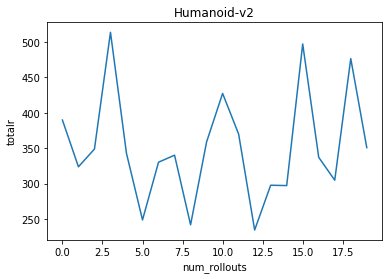

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
mean return -4.588576890409587
std of return 1.966419712378684
dimension of obs : (1000, 11)
dimension of actions : (1000, 1, 2)
Creating window glfw
mean return -14.04097386078261
std of return 3.205155590992587


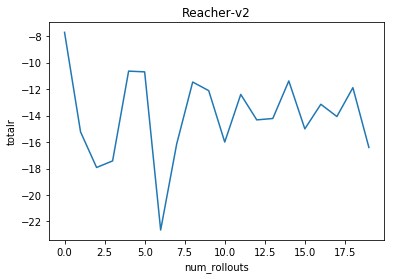

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
mean return 227.9763564315753
std of return 0.5355696818181896
dimension of obs : (2000, 11)
dimension of actions : (2000, 1, 3)
Creating window glfw
mean return 281.29328491373934
std of return 37.21353500420784


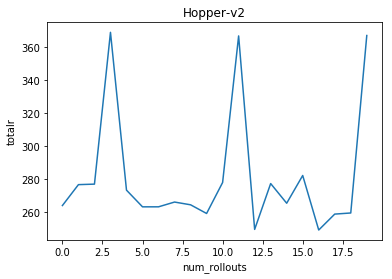

In [10]:
#Графики отдачи в зависимости от количества набранной статистики для обучения для окружений 
#Humanoid-v2, Reacher-v2 и Hopper-v2

env_name1 = "Humanoid-v2"
env_var1 = apply_env(env_name1)
results1 = use_model(env = env_var1[0], policy_fn = env_var1[1])
plt.title(env_name1)
plt.ylabel("totalr")
plt.xlabel("num_rollouts")
plt.plot(results1[0], results1[1])
plt.show()
#
env_name2 = "Reacher-v2"
env_var2 = apply_env(env_name2)
results2 = use_model(env = env_var2[0], policy_fn = env_var2[1])
plt.title(env_name2)
plt.ylabel("totalr")
plt.xlabel("num_rollouts")
plt.plot(results2[0], results2[1])
plt.show()
#
env_name3 = "Hopper-v2"
env_var3 = apply_env(env_name3)
results3 = use_model(env = env_var3[0], policy_fn = env_var3[1])
plt.title(env_name3)
plt.ylabel("totalr")
plt.xlabel("num_rollouts")
plt.plot(results3[0], results3[1])
plt.show()

In [ ]:
# По построенным графикам четкой зависимости между параметром отдачи и колличеством набранной статистики 
# не прослеживается. Все графики имеют множество локальных минимумов и локальных максимумов на рассматриваемом 
# промежутке num_rollouts [1, 20]

__Задание 1.2.__ Выберите один из гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте график влияния значения этого параметра на качество обучения (totalr).

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
mean return 643.6841454790027
std of return 7.836143282051434
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
Creating window glfw
mean return 347.4408370020697
std of return 170.40327885633508
mean return 642.3209391755024
std of return 6.910686490986363
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
mean return 244.695007465743
std of return 46.83233267333896
mean return 643.2380529586073
std of return 8.66872104189602
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
mean return 221.74554131023632
std of return 48.225386469790074
mean return 639.7610138480719
std of return 9.825319122716266
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
mean return 205.3170299839152
std of return 23.415332947570256
mean return 638.9419727944336
std of return 8.360968959009988
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
mean 

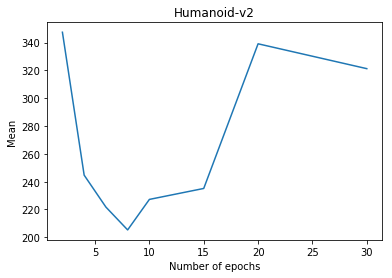

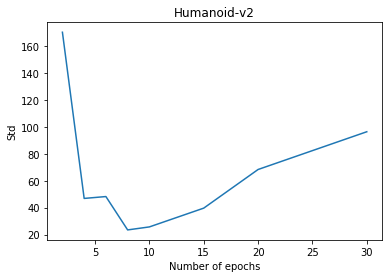

In [11]:
# Графики влияния гиперпараметра (количества эпох при обучении) на качество обучения 
#(среднее значение отдач и стандартное отклонение) для окружения "Humanoid-v2"

env_name = "Humanoid-v2"
env_var = apply_env(env_name)
means = []
stds = []

# Список количества эпох обучения модели
ep_list = [2, 4, 6, 8, 10, 15, 20, 30]
for i in ep_list:
    results = use_model(env = env_var[0], policy_fn = env_var[1], epochs = i)
    means.append(results[2])
    stds.append(results[3])
    
# Зависимость: Среднее значение (от количества эпох обучения)  
plt.title(env_name)
plt.ylabel("Mean")
plt.xlabel("Number of epochs")
plt.plot(ep_list, means)
plt.show()

# Зависимость: Стандартное отклонение (от количества эпох обучения)
plt.title(env_name)
plt.ylabel("Std")
plt.xlabel("Number of epochs")
plt.plot(ep_list, stds)
plt.show()

In [ ]:
# На рассматриваемом промежутке как среднее значение параметра качества обучения, так и его стандартное отклонение
# достигли своего минимума при количестве эпох = 8. 
# На интервале [1; 8] оба графика убывают, а далее - оба возрастают

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

![image.png](attachment:image.png)

In [12]:
def gen_data_use_model(env_name):
    env_var = apply_env(env_name)
    env = env_var[0]
    policy_fn = env_var[1]

    # generate expert data
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False,env=env,policy_fn=policy_fn);
    x = data['observations']
    y = data['actions']
    print ('dimension of obs :', x.shape)
    print('dimension of actions :', y.shape)

    # shuffle data
    x,y = shuffle(x,y)

    # create an object from BC_Model class, and train it
    cloner=BC_Model(x,y)
    cloner.train()

    with tf.Session():
        DAgger_iter=30
        render=False
        # DAgger loop
        for i in range(DAgger_iter):
            # reset in each iteration
            new_obs = []
            new_actions = []
            obs = env.reset()
            done = False
            # collect data from model and expert
            while not done:
                # get an action from the model
                
                ### Использование обученной модели
                action = cloner.sample(obs)
            
                obs, _, done, _ = env.step(action)
                if render:
                    env.render()
                # get the expert action for the same input
                
                corrected_action = policy_fn(obs[None, :])
            
                # append the observation and expert action to the data set
                new_obs.append(obs)
                new_actions.append(corrected_action)
            # re-order the data
            x = np.concatenate((x, obs[None, :]), axis = 0)
            y = np.concatenate((y, corrected_action[None, :]), axis = 0)
            # train the model on the collected data
            
            cloner.train(train_data = np.array(new_obs), test_data = np.array(new_actions))
    return (env, cloner)

### Проверяем работу

In [13]:
def check_work_draw(env, cloner):
    num_eval_rollouts=20
    # loop over runouts
    returns=[]
    for i in range(num_eval_rollouts):
        # reset variables in each iteration
        totalr=0
        done=False
        obs=env.reset()
        # loop until the end of the episode
        while not done:
            # get an action from the trained model (output for specific observation as input)
            action=cloner.sample(obs)
            # implement the action
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))
    return returns

__Задание 2.1.__ Проверьте работу DAagger на всех задачах MoJoCo - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.

In [ ]:
#Графическое сравнение качества работы метода DAgger и простого клонирования для всех задач MoJoCo 
#(для сред: "Humanoid-v2", "Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Reacher-v2", "Walker2d-v2")

Humanoid-v2
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
mean return 641.7587960056262
std of return 8.873301540626738
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
Creating window glfw
mean return 133.11305200112366
std of return 43.62590891789194


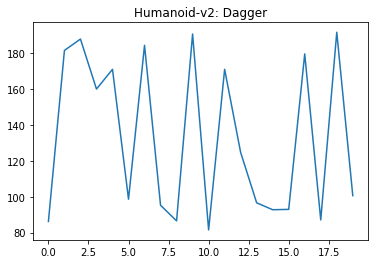

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
mean return 643.0280555413931
std of return 7.352735820676925
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)
mean return 289.04218534368187
std of return 37.51611396614244


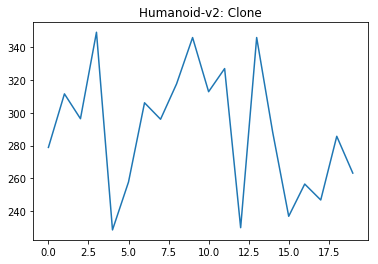

Ant-v2
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
mean return 399.86086633952357
std of return 26.50281115068089
dimension of obs : (2000, 111)
dimension of actions : (2000, 1, 8)


In [ ]:
env_names=["Humanoid-v2", "Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Reacher-v2", "Walker2d-v2"]

# Обучение моделей и построение графиков для каждой из сред
for en in env_names:
    print(en)
    
    # DAgger
    model_vars = gen_data_use_model(en)
    dagger_res = check_work_draw(model_vars[0], model_vars[1])
    plt.title(en+": Dagger")
    plt.plot(dagger_res)
    plt.show()
    
    # Клонирование
    env_var = apply_env(env_name1)
    clone_res = use_model(env = env_var1[0], policy_fn = env_var1[1])
    plt.title(en+": Clone")
    plt.plot(clone_res[0], clone_res[1])
    plt.show()

In [ ]:
# По построенным графикам видно, что DАgger отработал существенно лучше клонирования лишь в среде "HalfCheetah-v2"